In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
# from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
cg = {'a','b','c','d'}
OHEs = {}
Scalers = {}
for x in cg:
    Scalers[x] = StandardScaler()
    OHEs[x] = OneHotEncoder()

In [27]:
TTS_DICT = {
        'a':['50','50'],
        'b':['60',"40"],
        'c':['75','25'],
        'd':['80','20']
    }

TTS_DICT_INV = {
        '50':'a',
        '40':'b',
        '25':'c',
        '20':'d'    
    }

print(TTS_DICT_INV)

TTS_BASE_DIR = os.path.abspath('Train_Test_Data_Splits')
TTS_FILE_LIST = os.listdir(TTS_BASE_DIR)
print(TTS_FILE_LIST)

{'50': 'a', '40': 'b', '25': 'c', '20': 'd'}
['tts_test_50_50.csv', 'tts_test_60_40.csv', 'tts_test_75_25.csv', 'tts_test_80_20.csv', 'tts_train_50_50.csv', 'tts_train_60_40.csv', 'tts_train_75_25.csv', 'tts_train_80_20.csv']


In [45]:
x_trains = {}
y_trains= {}
x_tests = {}
y_tests = {}

for tts_file in TTS_FILE_LIST:
    tts_file_path = os.path.join(TTS_BASE_DIR,tts_file)
    df = pd.read_csv(tts_file_path,index_col=False)
    tts_file_wo_ext = tts_file.split('.')[0].split('_')
    k = TTS_DICT_INV[tts_file_wo_ext[-1]]
    if 'train' in tts_file_wo_ext:
        #depend on test set size
        x_trains[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
        x_trains[k] = np.expand_dims(x_trains[k], axis=2)
        y_trains[k]  = OHEs[k].fit_transform(df['Y_train'].values.reshape(-1,1)).toarray()
    else:
        x_tests[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
        x_tests[k] = np.expand_dims(x_tests[k], axis=2)
        y_tests[k]  = OHEs[k].fit_transform( df['Y_test'].values.reshape(-1,1)).toarray()
     
        

---
## Model 1
----

In [46]:
MODEL_BASE_DIR = os.path.abspath('Models')

In [47]:
def model_1(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 1, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

In [48]:
# # making our data compatible to model.
# x_train = np.expand_dims(x_train, axis=2)
# x_test = np.expand_dims(x_test, axis=2)

In [66]:
Model_1_dict = {}
for k in cg:
    Model_1_dict[k] = model_1(x_trains[k])

----
# Model 1 Traing For Different Train Test Split
  Train    |   Test
  - 50-50
  - 60-50
  - 75-25
  - 80-20
----

In [70]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_1')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_1'))

In [71]:
HISTORIES = {}

In [72]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
epoch = 40

for k in cg:
    print("-------------------")
    print(f"Traing is done for Model 1")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    HISTORIES[k] = Model_1_dict[k].fit(x_trains[k], y_trains[k], 
                                batch_size=64, 
                                epochs=epoch, 
                                validation_split=.25, 
                                callbacks=[rlrp])
    
    Model_1_dict[k].save(os.path.join("Models",'model_1',f"model_1_{'_'.join(TTS_DICT[k])}.h5"))

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/40
26/26 [==============================] - 2s 55ms/step - loss: 1.9981 - accuracy: 0.1747 - val_loss: 1.9204 - val_accuracy: 0.2685
Epoch 2/40
26/26 [==============================] - 1s 50ms/step - loss: 1.9026 - accuracy: 0.2691 - val_loss: 1.8534 - val_accuracy: 0.3019
Epoch 3/40
26/26 [==============================] - 2s 86ms/step - loss: 1.8175 - accuracy: 0.3185 - val_loss: 1.7120 - val_accuracy: 0.3370
Epoch 4/40
26/26 [==============================] - 1s 39ms/step - loss: 1.7380 - accuracy: 0.3414 - val_loss: 1.6765 - val_accuracy: 0.3667
Epoch 5/40
26/26 [==============================] - 1s 50ms/step - loss: 1.6731 - accuracy: 0.3728 - val_loss: 1.5737 - val_accuracy: 0.4259
Epoch 6/40
26/26 [==============================] - 1s 36ms/step - loss: 1.6337 - accuracy: 0.3765 - val_loss: 1.5312 - val_accuracy: 

In [73]:

def loss_accuracy_details(model,history,epoch,x_test,y_test):
    print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
    
    epochs = [i for i in range(epoch)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
68/68 [==============================] - 0s 5ms/step - loss: 1.1693 - accuracy: 0.6227
Accuracy of our model on test data :  62.26851940155029 %


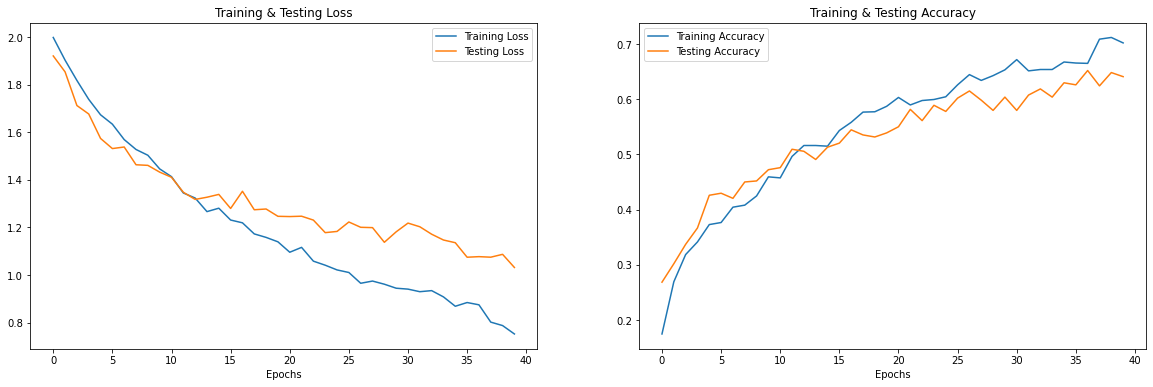

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
54/54 [==============================] - 1s 7ms/step - loss: 0.9877 - accuracy: 0.6591
Accuracy of our model on test data :  65.91435074806213 %


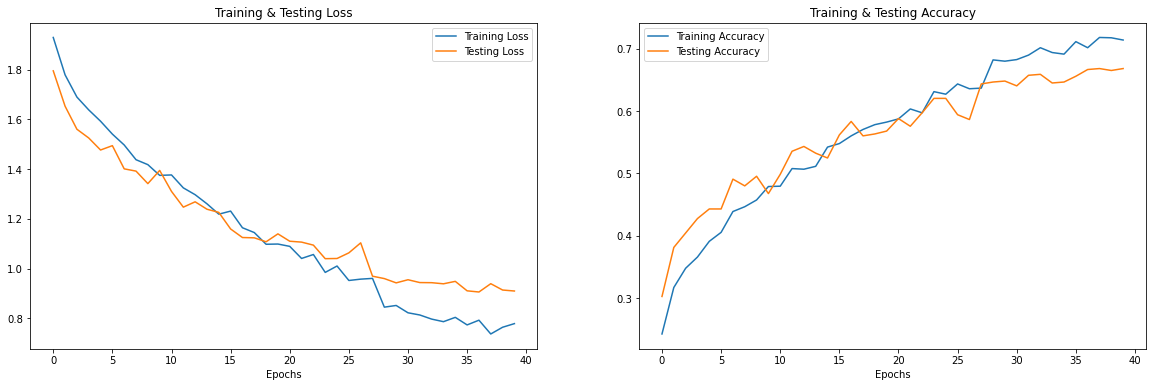

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
27/27 [==============================] - 0s 7ms/step - loss: 1.0124 - accuracy: 0.6840
Accuracy of our model on test data :  68.40277910232544 %


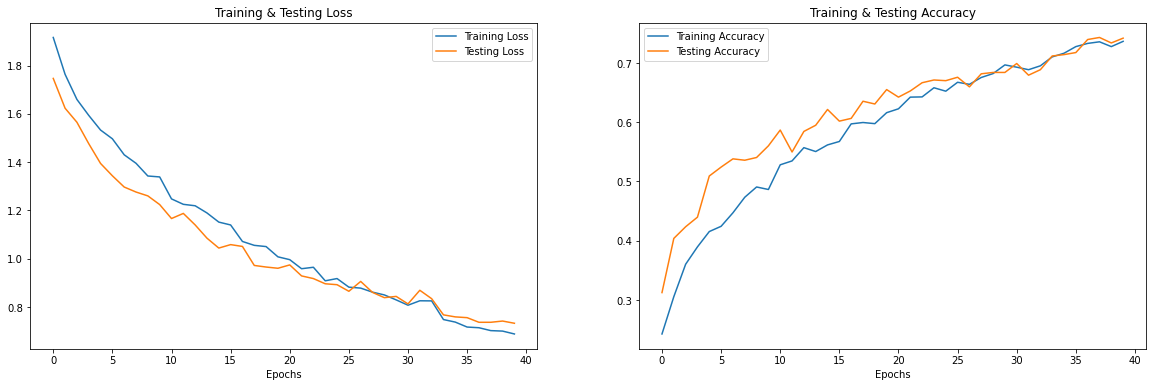

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
34/34 [==============================] - 0s 6ms/step - loss: 0.9872 - accuracy: 0.6389
Accuracy of our model on test data :  63.88888955116272 %


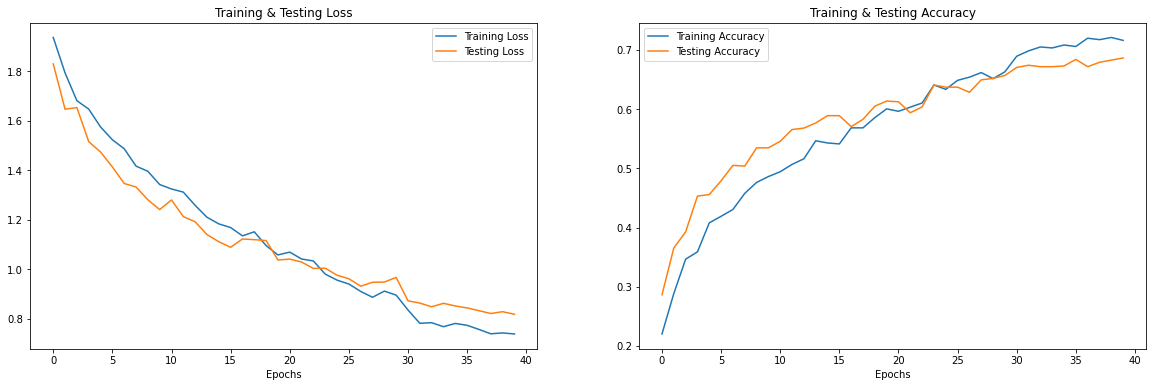

In [75]:
epoch = 40

for k in cg:
    print("-------------------")
    print(f"Traing is done for Model 1")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    loss_accuracy_details(Model_1_dict[k],HISTORIES[k],epoch,x_tests[k],y_tests[k])